## stacking 集成算法-只有付费记录：次级学习器融合-深度神经网络
- 8 神经网络回归

In [1]:
# 导入必要的工具包
import numpy as np #用于数值计算
import pandas as pd #用于数据表处理，数据文件读写
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 

import time
from sklearn.model_selection import cross_val_score, train_test_split
import tensorflow as tf

import matplotlib.pyplot as plt #用于绘图：分析结果的可视化。
#应该是设置浮点数的形式格式，小数点后三位
pd.set_option('display.float_format', lambda x: '%.4f' % x)
#这一行是干嘛的？ 设置 matplotlib 让绘制的图形出现在 Notebook 里而不是新窗口
%matplotlib inline

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_train_val(val_id):
    '''获取训练集和校验集 
    val_id = 0,1,2 #当前校验集编号 '''
    print('val_id=%s'% (val_id))
    df_val = train_list[val_id]
    train_tmp = []

    for i in range(1, train_part_num):
        cur_id = (val_id + i) % 5
        print('cur_id=%s'% (cur_id))
        train_tmp.append(train_list[cur_id])
    
#     只生成一次，节省内存 
    df_train = pd.concat(train_tmp)
    print('df_train.shape=%s  df_val.shape=%s'% (df_train.shape, df_val.shape))
    return df_train, df_val

In [3]:
Y_Standard = True
path_train = '../data/new/train=predict/'
path_test = '../data/new/test=predict/'

val_path = '../data/val/second/' #保存校验集测试结果
val_name = '%sval=stacking-%s-%s.csv'
summit_path = '../data/summit/stacking-second/' #保存提交文件，测试集测试结果 
out_name = '%ssummit=stacking-%s-%s.csv' # 生成的结果文件名称
base = 'second' #学习器级别 

train_part_num = 5 #训练集拆分个数
target = 'prediction_pay_price'
user_id = 'user_id'

## 指定读取数据类型，节省内存

In [4]:
col_int32 = ['user_id']
col_float32 = ['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7']

In [5]:
# 指定读取数据类型，节省内存
dtype_test = {}
for col in col_int32:
    dtype_test[col] = np.int32
for col in col_float32:
    dtype_test[col] = np.float32
# dtype_test

In [6]:
dtype_train = dtype_test.copy()
dtype_train[target] = np.float32
# dtype_train

## 读取数据，一次读取多次使用，不同组合 

In [7]:
train_list = []
for i in range(train_part_num):
    cur_id = i + 1
    train_list.append(pd.read_csv('%strain=pred-1-col=9-target-%s.csv' % (path_train, cur_id), dtype=dtype_train))
train_list[0].head()

,user_id,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,prediction_pay_price
0,332994,0.0000,0.0001,0.0000,0.3495,0.0001,0.0000,0.0000,0.0001,0.0000
1,2186887,0.1648,0.0001,0.0000,0.3495,0.0046,0.0000,0.1085,0.0002,0.0000
2,383991,0.1635,0.0001,0.0000,0.3495,0.0001,0.0000,0.0527,0.0001,0.0000
3,102315,0.1576,0.0001,0.0000,0.3495,0.0002,0.0000,0.0576,0.0001,0.0000
4,225310,0.0000,0.0001,0.0000,0.3495,0.0007,0.0000,0.0131,0.0001,0.0000


## 5折交叉验证

In [8]:
# 根据校验集编号 0，1,2,3,4 ，获取训练集和校验集
df_train, df_val = get_train_val(4)

# 从原始数据中分离输入特征x和输出y
train_y = df_train[target].values
train_X = df_train.drop([target, user_id], axis = 1)
val_y = df_val[target].values
val_X = df_val.drop([target, user_id], axis = 1)

val_id=4
cur_id=0
cur_id=1
cur_id=2
cur_id=3
df_train.shape=(1830405, 10)  df_val.shape=(457602, 10)


In [9]:
# 数据标准化：分别初始化对特征和目标值的标准化器 
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
train_X_ss = ss_X.fit_transform(train_X)
val_X_ss = ss_X.transform(val_X)

if Y_Standard:
    train_y_ss = ss_y.fit_transform(train_y.reshape(-1, 1))
    val_y_ss = ss_y.transform(val_y.reshape(-1, 1))

# 需要转换为一维数组 
train_y_ss_1d = train_y_ss.reshape(train_y_ss.shape[0])
val_y_ss_1d = val_y_ss.reshape(val_y_ss.shape[0])

In [10]:
print(val_X_ss.shape)
print(train_X_ss.shape)
print(train_y_ss.shape)

(457602, 8)
(1830405, 8)
(1830405, 1)


In [11]:
def inverse_StandardScaler(predict):
    ''' 标准化数据还原  '''    
    if Y_Standard:
        predict = ss_y.inverse_transform(predict)
        print('predict = ', predict)
    return predict

def generate_summit(predict):
    ''' 输出预测后的数据 '''
    testPredict = test.copy()
    testPredict[target] = predict
    testPredict = testPredict[[user_id, target]]
#     应该过滤掉负数
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

def generate_val_predict(predict):
    ''' 生成校验集预测后的数据 '''
    testPredict = df_val.copy()
    testPredict[target] = predict
    testPredict = testPredict[[user_id, target]]
#     应该过滤掉负数
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

## 加载测试数据

In [12]:
test = pd.read_csv(path_test + 'test=pred-1-col=9.csv', dtype=dtype_test)
test_X = test.drop([user_id], axis = 1)
test_X_ss = ss_X.transform(test_X)
test.head()

,user_id,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7
0,14933,0.0842,0.0002,0.0079,0.4069,0.0001,0.0102,1.6502,0.0002
1,14934,0.0592,0.0001,0.0000,0.4069,0.0000,0.0000,0.6719,0.0001
2,14935,0.3927,0.0001,0.0000,0.4069,0.0000,0.0000,0.9312,0.0001
3,14936,1.5131,0.0063,0.2355,0.4069,0.0000,0.2351,1.3646,0.0001
4,14937,0.0000,0.0001,0.0000,0.4069,0.0000,0.0000,0.5996,0.0001


## 模型训练
###  8 神经网络回归

In [13]:
def add_layer(inputs, in_size, out_size, activation_function=None):
    '''添加层，返回本层的输出项
    in_size 输入节点个数
    out_size 输出节点个数
    '''
    #在ReLU 激活函数中推荐使用 Xavier 初始化的变种，暂且称之为 He Initialization：
    Weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.5)) / np.sqrt(in_size / 2)
    
    #计算正则项，加入集合losses里面
#     reg = tf.contrib.layers.l1_regularizer(0.001)(Weights)
    reg = tf.contrib.layers.l1_regularizer(0.01)(Weights)
#     reg = tf.contrib.layers.l1_regularizer(0.02)(Weights)
#     reg = tf.contrib.layers.l1_regularizer(0.1)(Weights)
    tf.add_to_collection("losses", reg)
    
    # 偏置初始化分布参数设置  
    biases = tf.Variable(tf.constant(1.0, shape=[out_size]))
#     biases = tf.Variable(tf.constant(0.1, shape=[out_size]))
#     biases = tf.Variable(tf.constant(0.01, shape=[out_size]))
    
    Wx_plus_b = tf.matmul(inputs, Weights) + biases
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    return outputs

In [14]:
# 定义网络结构
n_input = train_X_ss.shape[1]
n_output = train_y_ss.shape[1]
tf_x = tf.placeholder(tf.float32, [None,n_input])     # input x
tf_y = tf.placeholder(tf.float32, [None,n_output])     # input y

# 神经元数量=数据维度 ,添加隐层，调整神经元个数，看看效果 
# layer_dim = [n_input, 107, n_output]
# layer_dim = [n_input, 107, 50, n_output]
# layer_dim = [n_input, 107, 50, 20, n_output]
# layer_dim = [n_input, 55, 27, n_output]
# layer_dim = [n_input, n_input*4, n_input*2, n_output]
layer_dim = [n_input, n_input*2, n_input*1, n_output]
# layer_dim = [n_input, n_input*1, n_input//2, n_output]
n_layers = len(layer_dim) #神经网络的层数

output_layer = tf_x
in_dimension = layer_dim[0]
for i in range (1, n_layers):
    out_dimension = layer_dim[i]
    if out_dimension == n_output:
        active_fun = None 
    else: #调整激活函数
#         active_fun = tf.nn.relu6
        active_fun = tf.nn.relu
    # 添加层：有 out_dimension 个神经元 
    output_layer = add_layer(output_layer, in_dimension, out_dimension, activation_function=active_fun)
    in_dimension = layer_dim[i]
    output_layer = tf.layers.batch_normalization(output_layer) #加快收敛
    output_layer = tf.layers.dropout(output_layer, rate=0.1) #防止过拟合
#     output_layer = tf.layers.dropout(output_layer, rate=0.2) #防止过拟合

loss = tf.losses.mean_squared_error(tf_y, output_layer)   # compute cost 损失函数 
tf.add_to_collection("losses", loss)#把交叉熵损失，也加入到集合里

# 调整优化器和学习率 
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

In [15]:
def model_validation(epoch):
    ''' 模型校验 '''
#     train_loss = sess.run(loss, {tf_x: X_train_part, 
#                                     tf_y: y_train_part})
    val_loss, val_pred = sess.run([loss, output_layer], {tf_x: val_X_ss, 
                                    tf_y: val_y_ss})
    if epoch % 1 == 0:
        print('---------------- epoch=%s  val_loss=%s' % (epoch+1, val_loss))
    
    return val_loss, val_pred

In [16]:
# 训练参数
n_sample = train_X_ss.shape[0]
# batch_size = int(n_sample / 2)
# batch_size = 20592
# batch_size = 457602
batch_size = 228801
# batch_size = 114400
n_step = int(np.ceil(n_sample / batch_size))
n_epoch = 50
early_stopping_max = 10
early_stopping_threshold = 0.2
print('n_sample=%s batch_size=%s n_step=%s n_epoch=%s' % (n_sample, batch_size, n_step, n_epoch))

n_sample=1830405 batch_size=228801 n_step=8 n_epoch=50


In [17]:
# 进行训练
sess = tf.Session()
sess.run(tf.global_variables_initializer())         # initialize var in graph
loss_train_arr = []
loss_val_arr = []
time_count = []
# losses = []
early_stopping_n = 0
random_train = True #是否随机 batch 

for epoch in range(n_epoch):
    ticks = time.time()
#     print('=============== epoch=%s' % (epoch+1))
    for step in range(n_step):
        # train and net output
        if random_train:# 随机取训练集
            _, batch_X, _, batch_y = train_test_split(train_X_ss, train_y_ss, random_state=33, test_size=batch_size)
        else:# 固定截取一段训练集
            i_from = step * batch_size
            i_to = (step+1) * batch_size
            if i_to > (n_sample - 1): #索引越界处理 
                i_to = (n_sample - 1)
            batch_X, batch_y = train_X_ss[i_from:i_to], train_y_ss[i_from:i_to]
#         print('batch_X.shape=%s  batch_y.shape=%s' % (batch_X.shape, batch_y.shape))
        _, loss_v, pred = sess.run([train_op, loss, output_layer], {tf_x: batch_X, 
                                                         tf_y: batch_y})
        
#         losses.append(loss_v)
#         if step % 5 == 0:
#             print('step=%s loss=%s' % (step+1, loss_v))
    mean_loss = loss_v # np.mean(losses)
    loss_train_arr.append(mean_loss)
    val_loss, val_pred = model_validation(epoch)
    loss_val_arr.append(val_loss)
    ticks = np.round((time.time() - ticks) * 100) / 100
    time_count.append(ticks)
    if epoch % 1 == 0:
        print('%ss/epoch  loss=%s' % (ticks, mean_loss))
    if val_loss < early_stopping_threshold:
        early_stopping_n += 1
        if early_stopping_n > early_stopping_max:
            break

time_total = np.sum(time_count)
print('time_total=%ss time_epoch=%s'%(time_total, time_count[0]))

---------------- epoch=1  val_loss=2.6771355
3.56s/epoch  loss=2.7444985
---------------- epoch=2  val_loss=2.2232826
3.54s/epoch  loss=2.280939
---------------- epoch=3  val_loss=1.8457713
3.51s/epoch  loss=1.89478
---------------- epoch=4  val_loss=1.5389384
3.53s/epoch  loss=1.5796533
---------------- epoch=5  val_loss=1.2936149
3.53s/epoch  loss=1.3270497
---------------- epoch=6  val_loss=1.1005458
3.54s/epoch  loss=1.1276494
---------------- epoch=7  val_loss=0.9503306
3.53s/epoch  loss=0.97212297
---------------- epoch=8  val_loss=0.8352527
3.55s/epoch  loss=0.85251695
---------------- epoch=9  val_loss=0.7481921
3.52s/epoch  loss=0.7616574
---------------- epoch=10  val_loss=0.68345666
3.52s/epoch  loss=0.69370806
---------------- epoch=11  val_loss=0.6358171
3.55s/epoch  loss=0.6430857
---------------- epoch=12  val_loss=0.6008084
3.51s/epoch  loss=0.60531217
---------------- epoch=13  val_loss=0.57492816
3.52s/epoch  loss=0.5767286
---------------- epoch=14  val_loss=0.555206

## 4. 训练结果可视化

In [18]:
# 训练次数，x 轴
# x = np.arange(0, n_epoch, 1)
x = np.arange(0, len(loss_val_arr), 1)

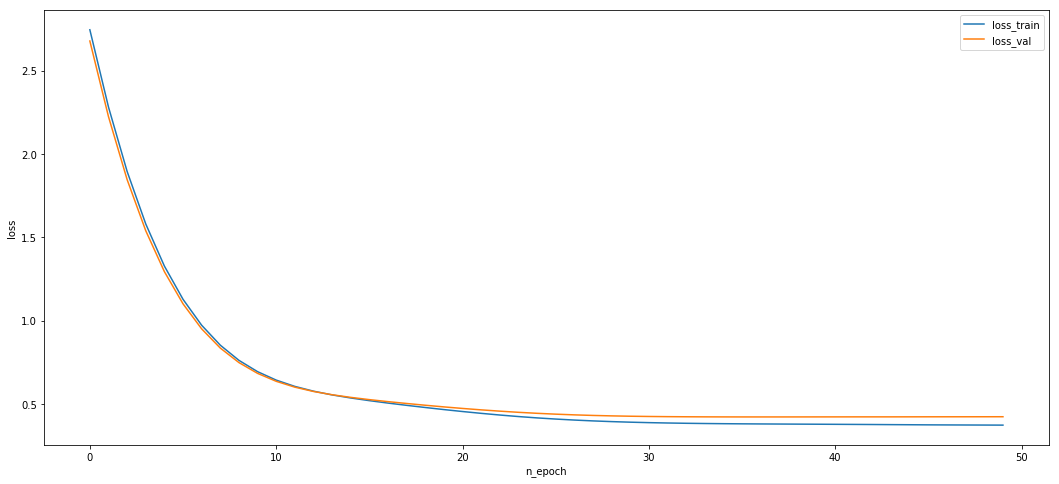

In [19]:
plt.figure(figsize=(18, 8))
# plt.plot(x, loss_train_arr, '-o', label='loss_train')
plt.plot(x, loss_train_arr, '-', label='loss_train')
plt.plot(x, loss_val_arr, '-', label='loss_val')

plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 5. 模型应用

In [20]:
print('val_pred= ', val_pred)
# 标准化数据还原 
predict_val = inverse_StandardScaler(val_pred)
valPredict = generate_val_predict(predict_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'DNN_V2'), index=False)
valPredict.head()

val_pred=  [[-0.00467398]
 [-0.02422741]
 [-0.02415662]
 ...
 [-0.02045652]
 [-0.02428448]
 [-0.02425331]]
predict =  [[ 1.4021618 ]
 [-0.3680239 ]
 [-0.3616145 ]
 ...
 [-0.02664189]
 [-0.37319043]
 [-0.37036827]]


,user_id,prediction_pay_price
0,1987367,1.4022
1,2292622,0.0000
2,466954,0.0000
3,1008130,0.0000
4,9759,0.0000


In [21]:
#对测试数据进行预测
test_pred = sess.run(output_layer, {tf_x:test_X_ss})
print('test_pred = ', test_pred)

# 标准化数据还原 
test_pred = inverse_StandardScaler(test_pred)

test_pred =  [[-0.02066283]
 [-0.02288207]
 [-0.02205972]
 ...
 [-0.01659217]
 [-0.02357522]
 [-0.02315721]]
predict =  [[-0.0453196 ]
 [-0.24622945]
 [-0.17178147]
 ...
 [ 0.3232002 ]
 [-0.30898073]
 [-0.27113798]]


In [22]:
#输出预测后的数据
testPredict = generate_summit(test_pred)
testPredict.to_csv(out_name %(summit_path, base, 'DNN_V2'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.0000
1,14934,0.0000
2,14935,0.0000
3,14936,0.1170
4,14937,0.0000


In [23]:
# 最后要关闭 
sess.close()